# Recommender Systems Surprise 

## Simple Python RecommendatIon System Engine.

https://surpriselib.com/

In [1]:
#!pip install scikit-surprise

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD, KNNBasic, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse, mae

In [3]:
# Sample data (user, item, rating)
data = [
    {"user": "Alice", "item": "Guitar", "rating": 5},
    {"user": "Alice", "item": "Drums", "rating": 3},
    {"user": "Alice", "item": "Violin", "rating": 4},  
    {"user": "Bob", "item": "Guitar", "rating": 1},
    {"user": "Bob", "item": "TV", "rating": 5},
    {"user": "Bob", "item": "Radio", "rating": 4},
    {"user": "Bob", "item": "Laptop", "rating": 3}, 
    {"user": "Charlie", "item": "Guitar", "rating": 4},
    {"user": "Charlie", "item": "Piano", "rating": 5},
    {"user": "Charlie", "item": "Drums", "rating": 4},
    {"user": "Charlie", "item": "Microphone", "rating": 3}, 
    {"user": "David", "item": "Guitar", "rating": 2}, 
    {"user": "David", "item": "Violin", "rating": 4},  
    {"user": "David", "item": "Piano", "rating": 3}, 
    {"user": "David", "item": "Microphone", "rating": 2}, 
]

# Convert data to DataFrame
df = pd.DataFrame(data)
df 

,user,item,rating
0,Alice,Guitar,5
1,Alice,Drums,3
2,Alice,Violin,4
3,Bob,Guitar,1
4,Bob,TV,5
5,Bob,Radio,4
6,Bob,Laptop,3
7,Charlie,Guitar,4
8,Charlie,Piano,5
9,Charlie,Drums,4


In [4]:
# Get unique item names
item_names = df['item'].unique()
item_names

array(['Guitar', 'Drums', 'Violin', 'TV', 'Radio', 'Laptop', 'Piano',
       'Microphone'], dtype=object)

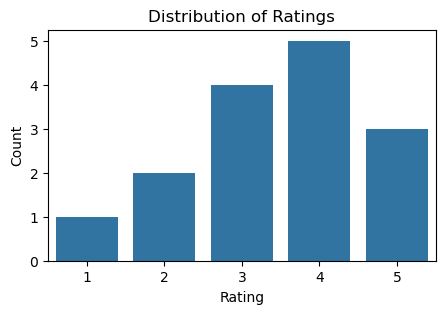

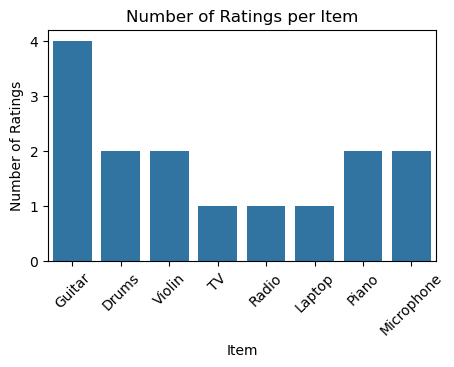

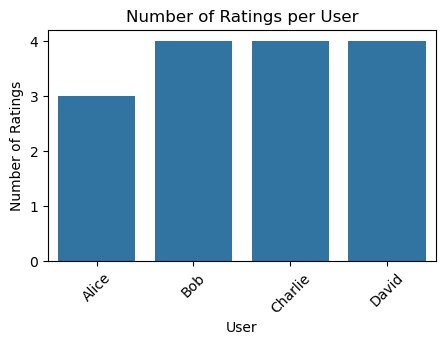

In [5]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(5, 3))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(5, 3))
sns.countplot(x='item', data=df)
plt.title('Number of Ratings per Item')
plt.xlabel('Item')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 3))
sns.countplot(x='user', data=df)
plt.title('Number of Ratings per User')
plt.xlabel('User')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Surprise requires a different format for data
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

# List of algorithms
algos = [SVD(), KNNBasic(), NMF(), SlopeOne(), CoClustering()]

In [7]:
# Cross-validation and algorithm comparison
cv_results_list = []
for algo in algos:
    print(f'\nAlgorithm: {algo.__class__.__name__}')
    cv_results = cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    print(f'RMSE: {cv_results["test_rmse"].mean()}')
    print(f'MAE: {cv_results["test_mae"].mean()}')
    cv_results_list.append(cv_results)



Algorithm: SVD
RMSE: 1.1476247111071332
MAE: 1.0421720240304904

Algorithm: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3911408418923377
MAE: 1.2611111111111113

Algorithm: NMF
RMSE: 1.299011987023239
MAE: 1.2265183299266327

Algorithm: SlopeOne
RMSE: 1.5192645564022484
MAE: 1.2444444444444445

Algorithm: CoClustering
RMSE: 1.1170737311106658
MAE: 0.9520634920634921


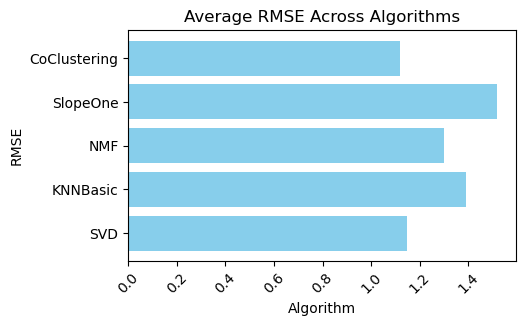

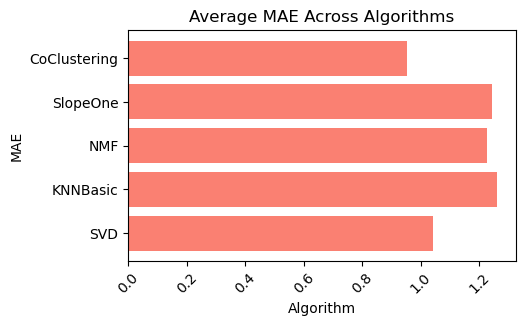

In [8]:
# Visualizing algorithm performance metrics
alg_names = [algo.__class__.__name__ for algo in algos]
rmse_scores = [cv_results['test_rmse'].mean() for cv_results in cv_results_list]
mae_scores = [cv_results['test_mae'].mean() for cv_results in cv_results_list]

plt.figure(figsize=(5, 3))
plt.barh(alg_names, rmse_scores, color='skyblue')
plt.title('Average RMSE Across Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 3))
plt.barh(alg_names, mae_scores, color='salmon')
plt.title('Average MAE Across Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()

## Hybrid Recommender

In [10]:
# Split the data into train and test sets
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Fit KNNBasic model
knn_basic = KNNBasic(sim_options={'user_based': False})
knn_basic.fit(trainset)

# Get the most popular items
popular_items = df['item'].value_counts().index.tolist()

# Define weights for each model
weight_knn = 0.7
weight_popularity = 0.3

# Hybrid recommender combining popularity and KNNBasic with weightage
def hybrid_recommend(user_id):
    # Collaborative filtering recommendations
    knn_recommendations = knn_basic.get_neighbors(trainset.to_inner_uid(user_id), k=3)
    knn_item_names = [trainset.to_raw_iid(inner_id) for inner_id in knn_recommendations]
    
    # Combine with popular items and apply weights
    hybrid_recommendations = knn_item_names[:2] + popular_items[:1]  # Taking top recommendations
    weighted_recommendations = [item for item in hybrid_recommendations for _ in range(int(len(hybrid_recommendations)/3))]
    
    return weighted_recommendations

# Example: Recommend items for user 'Alice'
user_id = 'Alice'
recommendations = hybrid_recommend(user_id)
print(f"Top recommendations for user '{user_id}': {recommendations}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Top recommendations for user 'Alice': ['Drums', 'Guitar', 'Guitar']
